In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", 
                        category=UserWarning, message=".* version 1.0.02 when using version 1.3.0.",
                        module='sklearn')
%matplotlib inline
import scipy.stats as stats

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression, LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data handling & visualization
from collections import Counter, OrderedDict
import missingno
from tabulate import tabulate

# Evaluation & metrics
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
)
from sklearn.metrics import (
    f1_score, accuracy_score, roc_auc_score, recall_score, precision_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay,
    precision_recall_curve, roc_curve, RocCurveDisplay, mean_absolute_error,
    mean_squared_error, r2_score, make_scorer
)

# Scaling
from sklearn.preprocessing import StandardScaler

# Ensemble & advanced models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Imbalanced data tools
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline   # important: imblearn pipeline

# Model saving
import joblib


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_csv("RBalanced_gbv_data.csv")

In [4]:
#renaming some columns

In [5]:
# Rename columns in df
df = df.rename(columns={
    "not_applicable": "vul_cat_if_applicable",
    "employment_status_victim_main": "individual_employment_status",
    "employment_status_main": "househead_employment_status",
    #"PLHIV": "living_with_HIV_status",
    "who_survivor/victim_stay_with": "current_living_arrangement",
    "victim_lives_with": "individual_lives_with",
    "survivor_sex": "gender",
    "survivor_age": "individual_age"
    #"IDP": "internally_displaced_person_status",
    #"marital status": "marital_status",
    #"educational status": "educational_attainment_level"
})

# Check updated columns
print(df.columns.tolist())

['organisation_type', 'organisation_state', 'organisation_lga', 'location_state', 'location_lga', 'current_living_arrangement', 'individual_lives_with', 'individual_age', 'gender', 'marital_status', 'househead_employment_status', 'individual_employment_status', 'PLWD', 'PLHIV', 'female_sex_worker', 'IDP', 'drug_user', 'widow', 'out_of_school_child', 'minor', 'household_help', 'child_apprentice', 'orphans', 'vul_cat_if_applicable', 'other_vulnerability', 'educational_status', 'incident_time_of_day', 'incident_location', 'sexual_assault', 'physical_assault', 'financial_economic', 'online_cyber', 'rape', 'defilement', 'forced_marriage', 'denial_of_resources', 'psychological_emotional_abuse', 'female_genital_mutilation', 'violation_property_inheritance_rights', 'child_abuse_neglect', 'other_violence', 'was_the_violence_fatal', 'perpetrator_sex', 'perpetrator_age', 'victim_perpetrator_relationship', 'contact_channel', 'who_reported_the_incident', 'seeks_justice', 'vulnerability_target', 'in

In [6]:
df.head(2)

,organisation_type,organisation_state,organisation_lga,location_state,location_lga,current_living_arrangement,individual_lives_with,individual_age,gender,marital_status,househead_employment_status,individual_employment_status,PLWD,PLHIV,female_sex_worker,IDP,drug_user,widow,out_of_school_child,minor,household_help,child_apprentice,orphans,vul_cat_if_applicable,other_vulnerability,educational_status,incident_time_of_day,incident_location,sexual_assault,physical_assault,financial_economic,online_cyber,rape,defilement,forced_marriage,denial_of_resources,psychological_emotional_abuse,female_genital_mutilation,violation_property_inheritance_rights,child_abuse_neglect,other_violence,was_the_violence_fatal,perpetrator_sex,perpetrator_age,victim_perpetrator_relationship,contact_channel,who_reported_the_incident,seeks_justice,vulnerability_target,incident_year,incident_month,incident_day,reported_year,reported_month,reported_day,location_ward_encoded
0,0,970001.0,970101.0,970001.0,971102.0,-1.000000,3.000000,21.0,0,0.000000,-1.000000,0.000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0.000000,1.000000,-1.000000,0,0,0,0,1,0,0,0,0,0,0,0,-1.00000,0.000000,1.000000,26.0,-1.000000,1.000000,1.000000,0.000000,1,2022.0,9.0,19.0,2022.0,9.0,21.0,1.000000
1,0,99.0,99.0,99.0,99.0,-0.139825,-0.339023,1.0,0,-0.294025,0.195355,-0.099031,0,0,0,0,0,0,0,0,0,0,0,0,0,0.059672,-0.067099,0.017315,0,0,0,0,0,0,0,0,0,0,0,0,0.08549,-0.022732,-0.085186,1.0,0.069183,-0.144563,-0.161968,0.008517,1,2004.0,1.0,1.0,2013.0,1.0,1.0,0.098109


In [7]:
df1 = df.copy()

In [8]:
df['vulnerability_target'].value_counts()

vulnerability_target
0    31002
1    30348
Name: count, dtype: int64

In [9]:
# List of columns to drop
columns_to_drop = [
    "incident_time_of_day",
    "vulnerability_score",
    "organisation_type",
    "organisation_state",
    "organisation_lga",
    "location_state",
    "location_lga",
    "location_ward_encoded",
    "incident_location",
    "sexual_assault",
    "physical_assault",
    "financial_economic",
    "online_cyber",
    "rape",
    "defilement",
    "forced_marriage",
    "denial_of_resources",
    "psychological_emotional_abuse",
    "female_genital_mutilation",
    "violation_property_inheritance_rights",
    "child_abuse_neglect",
    "other_violence",
    "was_the_violence_fatal",
    "perpetrator_sex",
    "perpetrator_age",
    "victim_perpetrator_relationship",
    "contact_channel",
    "who_reported_the_incident",
    "seeks_justice",
    "incident_year",
    "incident_month",
    "incident_day",
    "reported_year",
    "reported_month",
    "minor",
    "widow",
    "_tmp_vulnerable",
    "Unnamed: 0",
    "reported_day"
]

# Drop the columns
df = df.drop(columns=columns_to_drop, errors="ignore")

In [10]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [11]:
target = "vulnerability_target"

X = df.drop(columns=[target])
y = df[target]

In [12]:
print("Feature shape:", X.shape)
print("Target distribution:\n", y.value_counts())

Feature shape: (61350, 19)
Target distribution:
 vulnerability_target
0    31002
1    30348
Name: count, dtype: int64


In [13]:
# =======================================
# Step 3: Train-Test Split
# =======================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)


Training shape: (49080, 19)
Testing shape: (12270, 19)


In [14]:
# Scikit-learn ML tools
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    roc_auc_score, 
    roc_curve, 
    precision_recall_curve, 
    accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns


In [15]:
# =======================================
# Step 4: Logistic Regression + Hyperparameter Tuning
# =======================================

# Pipeline: Scaling + Logistic Regression
pipe = Pipeline([
    ("scaler", StandardScaler()), 
    ("logreg", LogisticRegression(solver="liblinear", max_iter=500))
])

# Hyperparameters to tune
param_grid = {
    "logreg__penalty": ["l1", "l2"],       # Regularization type
    "logreg__C": [0.01, 0.1, 1, 10, 100], # Inverse of regularization strength
    "logreg__class_weight": [None, "balanced"] # Handle class balance
}

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1",  # F1 because we care about balance between precision & recall
    cv=cv,
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV Score (F1):", grid.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'logreg__C': 0.1, 'logreg__class_weight': None, 'logreg__penalty': 'l1'}
Best CV Score (F1): 0.9266812190771375


In [16]:
# =======================================
# Step 5: Evaluation on Test Data
# =======================================

best_model = grid.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # for AUC & confidence

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# AUC Score
auc = roc_auc_score(y_test, y_proba)
print("ROC AUC:", auc)



Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93      6200
           1       0.93      0.92      0.93      6070

    accuracy                           0.93     12270
   macro avg       0.93      0.93      0.93     12270
weighted avg       0.93      0.93      0.93     12270

Accuracy: 0.9276283618581908
ROC AUC: 0.9803628766540894


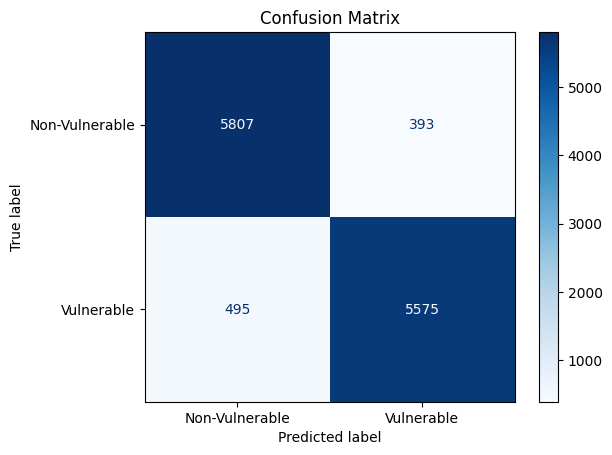

In [17]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Vulnerable", "Vulnerable"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

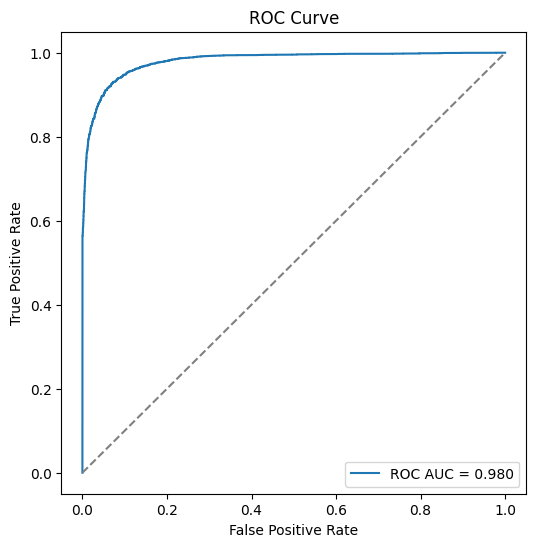

In [18]:
# =======================================
# Step 6: ROC & Precision-Recall Curves
# =======================================

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()



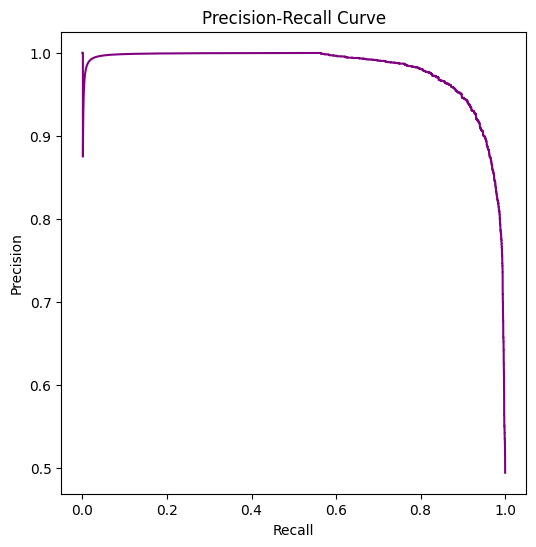

In [19]:
# Precision-Recall Curve
prec, rec, thr = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6, 6))
plt.plot(rec, prec, color="purple")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


In [20]:
# using threshold of 0.4

In [21]:
# =======================================
# Step 5: Evaluation on Test Data (Custom Threshold = 0.4)
# =======================================

best_model = grid.best_estimator_

# Predicted probabilities (not hard labels yet)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Apply custom threshold = 0.4
y_pred_custom = (y_proba >= 0.4).astype(int)

# Classification Report
print("\nClassification Report (Threshold = 0.4):\n", classification_report(y_test, y_pred_custom))

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_custom))

# AUC Score (threshold independent)
auc = roc_auc_score(y_test, y_proba)
print("ROC AUC:", auc)




Classification Report (Threshold = 0.4):
               precision    recall  f1-score   support

           0       0.94      0.91      0.92      6200
           1       0.91      0.94      0.93      6070

    accuracy                           0.92     12270
   macro avg       0.93      0.93      0.92     12270
weighted avg       0.93      0.92      0.92     12270

Accuracy: 0.9248573757131214
ROC AUC: 0.9803628766540894


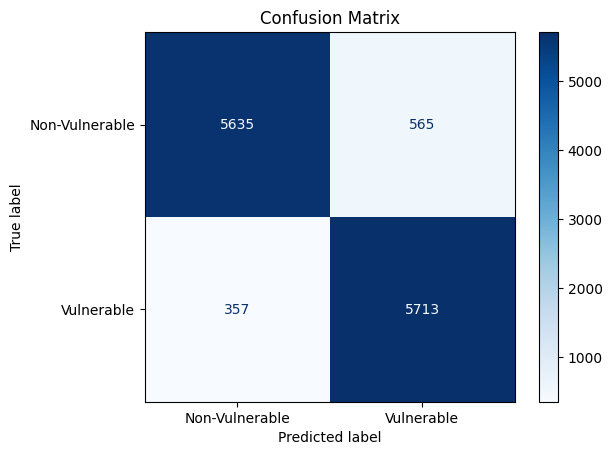

In [22]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_custom)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Vulnerable", "Vulnerable"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [23]:
# =======================================
# Step 7: Feature Importance (Logistic Regression Coefficients)
# =======================================

# Extract best model (from pipeline)
best_model = grid.best_estimator_

# Get feature names (from X)
feature_names = X.columns

# Extract coefficients (from logistic regression step in pipeline)
coefficients = best_model.named_steps["logreg"].coef_[0]

# Create DataFrame
feat_importance = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients,
    "Absolute_Importance": np.abs(coefficients)  # strength of effect
})

# Sort by absolute importance
feat_importance = feat_importance.sort_values(by="Absolute_Importance", ascending=False)

# Display top 10
print("\nTop 10 Important Features:\n", feat_importance.head(10))




Top 10 Important Features:
                          Feature  Coefficient  Absolute_Importance
2                 individual_age    -2.691411             2.691411
3                         gender    -2.652968             2.652968
0     current_living_arrangement    -0.975762             0.975762
16         vul_cat_if_applicable    -0.914038             0.914038
6   individual_employment_status    -0.631537             0.631537
1          individual_lives_with    -0.597104             0.597104
18            educational_status    -0.496442             0.496442
5    househead_employment_status     0.421248             0.421248
10                           IDP     0.188448             0.188448
7                           PLWD    -0.096288             0.096288


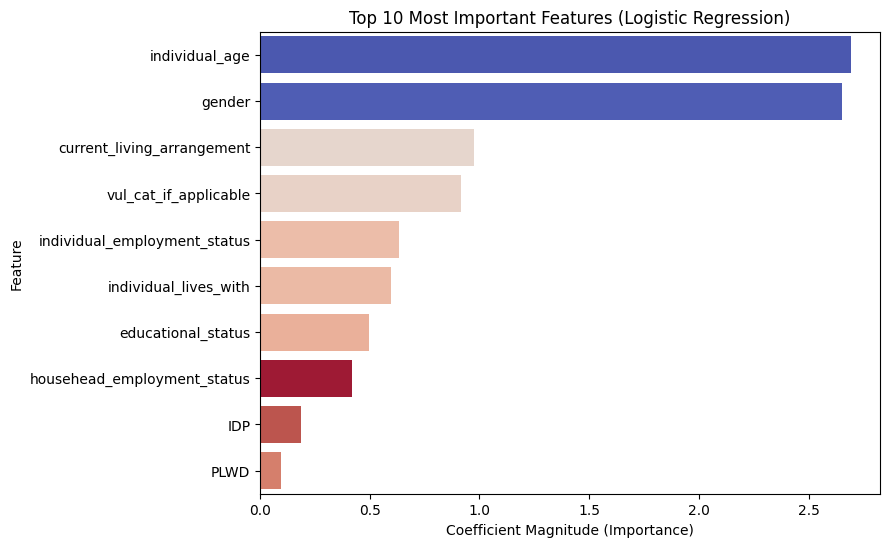

In [24]:
# Plot top 10
plt.figure(figsize=(8, 6))
sns.barplot(
    data=feat_importance.head(10), 
    x="Absolute_Importance", 
    y="Feature", 
    hue="Coefficient", 
    dodge=False,
    palette="coolwarm"
)
plt.title("Top 10 Most Important Features (Logistic Regression)")
plt.xlabel("Coefficient Magnitude (Importance)")
plt.ylabel("Feature")
plt.legend([],[], frameon=False)  # Hide legend for clarity
plt.show()

In [ ]:
#building model with random forest

In [26]:
# STEP 3: Baseline Random Forest
rf_baseline = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_baseline.fit(X_train, y_train)

# Predictions
y_rf_pred_baseline = rf_baseline.predict(X_test)
y_rf_prob_baseline = rf_baseline.predict_proba(X_test)[:, 1]

In [27]:
# STEP 4: Evaluate Baseline
print("=== BASELINE RANDOM FOREST ===")
print("Accuracy:", accuracy_score(y_test, y_rf_pred_baseline))
print("Precision:", precision_score(y_test, y_rf_pred_baseline))
print("Recall:", recall_score(y_test, y_rf_pred_baseline))
print("F1 Score:", f1_score(y_test, y_rf_pred_baseline))
print("ROC-AUC:", roc_auc_score(y_test, y_rf_prob_baseline))

print("\nClassification Report:\n", classification_report(y_test, y_rf_pred_baseline))

=== BASELINE RANDOM FOREST ===
Accuracy: 0.9941320293398533
Precision: 0.9942320369149638
Recall: 0.9939044481054365
F1 Score: 0.9940682155215027
ROC-AUC: 0.9995938247329542

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      6200
           1       0.99      0.99      0.99      6070

    accuracy                           0.99     12270
   macro avg       0.99      0.99      0.99     12270
weighted avg       0.99      0.99      0.99     12270



In [28]:
# STEP 5: Cross-validation setup
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [29]:
# STEP 6: Parameter distributions for RandomizedSearchCV
rf_param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

In [34]:
# STEP 7: RandomizedSearchCV (lighter version for speed)
rf_random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=rf_param_dist,
    n_iter=10,                 # sample only 10 random combos
    cv=3,                     
    scoring= 'f1',
    refit='f1_macro',
    n_jobs=-1,
    verbose=2,
    random_state=42
)


In [35]:
rf_random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 10],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 200]},
                   random_state=42, refit='f1_macro', scoring='f1', verbose=2)

In [36]:
print("Best Parameters from RandomizedSearchCV:\n", rf_random_search.best_params_)
print("Best CV F1 Score:", rf_random_search.best_score_)

Best Parameters from RandomizedSearchCV:
 {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Best CV F1 Score: 0.993479447165054


In [37]:
#evaluation

In [39]:
# STEP 10: Best tuned model
rf_best = rf_random_search.best_estimator_

# Predictions
y_rf_pred_best = rf_best.predict(X_test)
y_rf_prob_best = rf_best.predict_proba(X_test)[:, 1]

In [40]:
# STEP 11: Evaluation
print("=== TUNED RANDOM FOREST ===")
print("Accuracy:", accuracy_score(y_test, y_rf_pred_best))
print("Precision:", precision_score(y_test, y_rf_pred_best))
print("Recall:", recall_score(y_test, y_rf_pred_best))
print("F1 Score:", f1_score(y_test, y_rf_pred_best))
print("ROC-AUC:", roc_auc_score(y_test, y_rf_prob_best))

print("\nClassification Report:\n", classification_report(y_test, y_rf_pred_best))

=== TUNED RANDOM FOREST ===
Accuracy: 0.9940505297473513
Precision: 0.9942310862040548
Recall: 0.9937397034596376
F1 Score: 0.9939853341023317
ROC-AUC: 0.9996549795397778

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      6200
           1       0.99      0.99      0.99      6070

    accuracy                           0.99     12270
   macro avg       0.99      0.99      0.99     12270
weighted avg       0.99      0.99      0.99     12270



In [41]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

In [42]:
# --- STEP A: Evaluate TRAIN vs TEST performance ---
print("\n=== TRAIN vs TEST PERFORMANCE ===")

# Training predictions
y_rf_pred_train = rf_best.predict(X_train)
y_rf_prob_train = rf_best.predict_proba(X_train)[:, 1]

print("Train Performance:")
print("Accuracy:", accuracy_score(y_train, y_rf_pred_train))
print("Precision:", precision_score(y_train, y_rf_pred_train))
print("Recall:", recall_score(y_train, y_rf_pred_train))
print("F1 Score:", f1_score(y_train, y_rf_pred_train))
print("ROC-AUC:", roc_auc_score(y_train, y_rf_prob_train))


=== TRAIN vs TEST PERFORMANCE ===
Train Performance:
Accuracy: 0.9993887530562348
Precision: 0.9992998929248003
Recall: 0.9994645357937227
F1 Score: 0.9993822075782537
ROC-AUC: 0.9999899824452982


In [43]:

print("\nTest Performance:")
print("Accuracy:", accuracy_score(y_test, y_rf_pred_best))
print("Precision:", precision_score(y_test, y_rf_pred_best))
print("Recall:", recall_score(y_test, y_rf_pred_best))
print("F1 Score:", f1_score(y_test, y_rf_pred_best))
print("ROC-AUC:", roc_auc_score(y_test, y_rf_prob_best))



Test Performance:
Accuracy: 0.9940505297473513
Precision: 0.9942310862040548
Recall: 0.9937397034596376
F1 Score: 0.9939853341023317
ROC-AUC: 0.9996549795397778


In [44]:
# --- STEP B: 5-Fold Stratified Cross-Validation on tuned model ---
print("\n=== 5-FOLD CROSS-VALIDATION (Stratified) ===")

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(
    rf_best,
    X_train,
    y_train,
    cv=cv_strategy,
    scoring=["accuracy", "precision", "recall", "f1", "roc_auc"],
    return_train_score=True,
    n_jobs=-1
)

# Report mean ± std for each metric
for metric in ["train_accuracy", "train_precision", "train_recall", "train_f1", "train_roc_auc",
               "test_accuracy", "test_precision", "test_recall", "test_f1", "test_roc_auc"]:
    print(f"{metric}: {cv_results[metric].mean():.4f} ± {cv_results[metric].std():.4f}")



=== 5-FOLD CROSS-VALIDATION (Stratified) ===
train_accuracy: 0.9994 ± 0.0001
train_precision: 0.9994 ± 0.0001
train_recall: 0.9994 ± 0.0000
train_f1: 0.9994 ± 0.0001
train_roc_auc: 1.0000 ± 0.0000
test_accuracy: 0.9943 ± 0.0010
test_precision: 0.9957 ± 0.0011
test_recall: 0.9928 ± 0.0012
test_f1: 0.9942 ± 0.0010
test_roc_auc: 0.9996 ± 0.0001


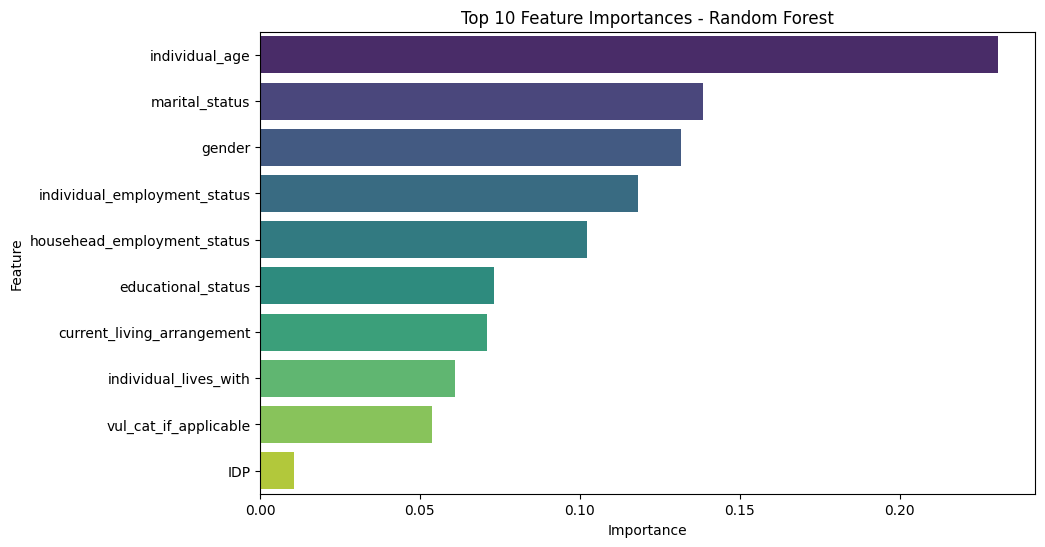

In [47]:
# STEP 14: Feature Importance
importances = rf_best.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices][:10], y=X.columns[indices][:10], palette="viridis")
plt.title("Top 10 Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [48]:
#building model with xgboost

In [49]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

In [50]:
# Step 3: Define baseline XGBoost model
xgb_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",  
    use_label_encoder=False,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [51]:
param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 4, 5],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}

In [52]:
xgb_random = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=10,     
    scoring="f1",           
    cv=3,                  
    verbose=1,
    n_jobs=-1,
    random_state=42
)

In [53]:
xgb_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=-1,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.7, 0.8, 1.0]},
                   random_state=42, scoring='f1', verbose=1)

In [54]:
print("Best Parameters:", xgb_random.best_params_)

best_xgb = xgb_random.best_estimator_

# Predictions
y_pred_xgb = best_xgb.predict(X_test)
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Confusion Matrix & Report
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

# ROC-AUC
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_xgb))


Best Parameters: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
[[6166   34]
 [  32 6038]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6200
           1       0.99      0.99      0.99      6070

    accuracy                           0.99     12270
   macro avg       0.99      0.99      0.99     12270
weighted avg       0.99      0.99      0.99     12270

ROC-AUC Score: 0.9997599511080406


In [55]:
print("\nConfusion Matrix (XGBoost):")
print(confusion_matrix(y_test, y_pred_xgb))


Confusion Matrix (XGBoost):
[[6166   34]
 [  32 6038]]


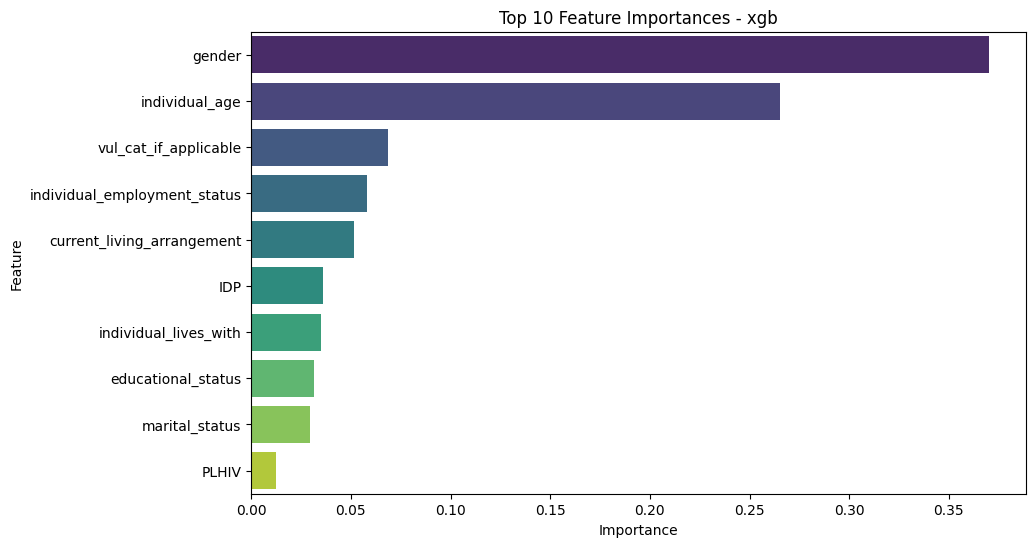

In [56]:
# STEP 14: Feature Importance
importances = best_xgb.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices][:10], y=X.columns[indices][:10], palette="viridis")
plt.title("Top 10 Feature Importances - xgb")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [57]:
# model building with catboost

In [58]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support

In [59]:
# Step 3: Define baseline CatBoost model
cat_model = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    random_state=42,
    iterations=500,            # not too big, will stop early
    learning_rate=0.05,
    depth=6,
    early_stopping_rounds=50,
    verbose=0                  # silent mode (no long logs)
)

In [60]:
# Step 4: Define smaller parameter grid for faster tuning
cat_param_grid = {
    "depth": [4, 6],
    "learning_rate": [0.05, 0.1],
    "l2_leaf_reg": [3, 5],
    "iterations": [300, 500]
}

# Stratified K-Fold CV (reduced folds for speed)
cat_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# GridSearchCV
cat_grid = GridSearchCV(
    estimator=cat_model,
    param_grid=cat_param_grid,
    cv=cat_cv,
    scoring="f1",   # balance between precision & recall
    n_jobs=-1,
    verbose=1
)
# Fit
cat_grid.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x0000022C4AE0C9A0>,
             n_jobs=-1,
             param_grid={'depth': [4, 6], 'iterations': [300, 500],
                         'l2_leaf_reg': [3, 5], 'learning_rate': [0.05, 0.1]},
             scoring='f1', verbose=1)

In [61]:
# Step 5: Best parameters
print("Best Parameters for CatBoost:", cat_grid.best_params_)

# Best model
cat_best = cat_grid.best_estimator_

Best Parameters for CatBoost: {'depth': 6, 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.1}


In [62]:
# Step 6: Predictions
y_pred_cat = cat_best.predict(X_test)
y_proba_cat = cat_best.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report for CatBoost:\n", classification_report(y_test, y_pred_cat))


Classification Report for CatBoost:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6200
           1       1.00      1.00      1.00      6070

    accuracy                           1.00     12270
   macro avg       1.00      1.00      1.00     12270
weighted avg       1.00      1.00      1.00     12270



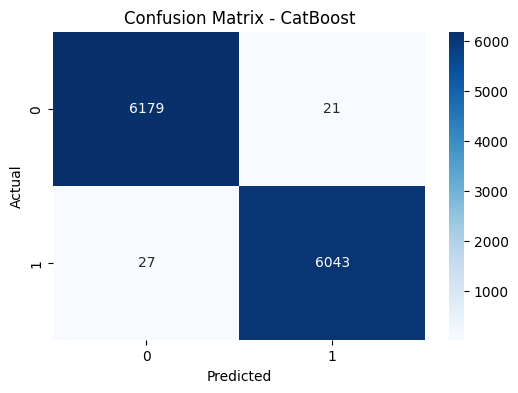

In [63]:
# Confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_cat), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - CatBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


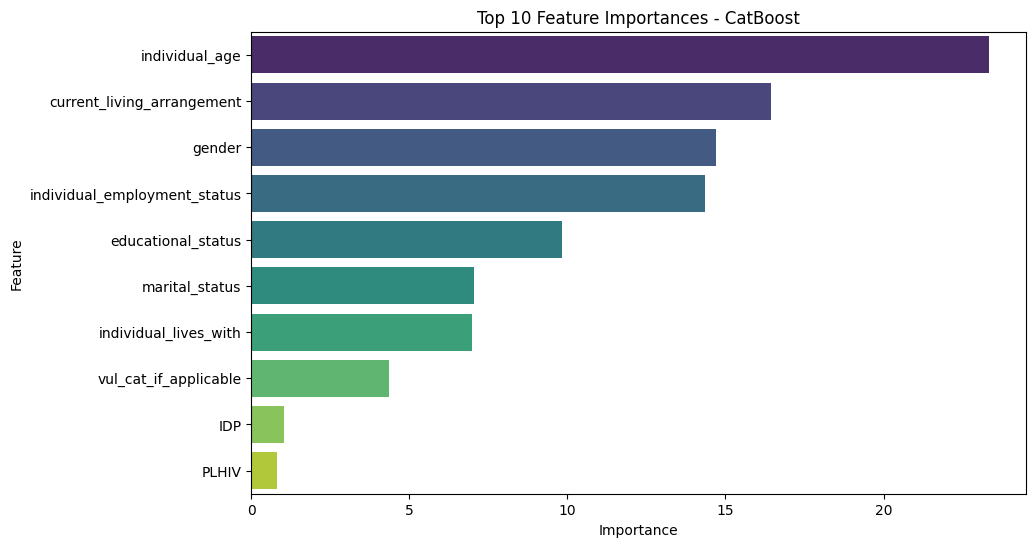

In [64]:
# Step 7: Feature importance
importances_cat = cat_best.get_feature_importance()
feat_imp_cat = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances_cat
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp_cat.head(10), x="Importance", y="Feature", palette="viridis")
plt.title("Top 10 Feature Importances - CatBoost")
plt.show()


In [66]:
df.head(2)

,current_living_arrangement,individual_lives_with,individual_age,gender,marital_status,househead_employment_status,individual_employment_status,PLWD,PLHIV,female_sex_worker,IDP,drug_user,out_of_school_child,household_help,child_apprentice,orphans,vul_cat_if_applicable,other_vulnerability,educational_status,vulnerability_target
0,-1.000000,3.000000,21.0,0,0.000000,-1.000000,0.000000,0,0,0,1,0,0,0,0,0,0,0,0.000000,1
1,-0.139825,-0.339023,1.0,0,-0.294025,0.195355,-0.099031,0,0,0,0,0,0,0,0,0,0,0,0.059672,1


In [68]:
#df.to_csv("gendbv_data.csv", index=False)

In [76]:
# GBV Model Selection and Best Model Saving
# Select and save the best model with multiple-metric weighted scoring

import os
import joblib
from sklearn.metrics import f1_score, log_loss, accuracy_score, roc_auc_score

# Define weights for your metrics
# Prioritize F1 and accuracy more than log loss
weight_f1 = 0.4
weight_accuracy = 0.4
weight_auc = 0.3
weight_logloss = 0.1  # Lower weight for log loss (penalty)

# Compute scores on test set for each model
model_scores = {}

# Logistic Regression
f1_lr = f1_score(y_test, y_pred, average='weighted')
accuracy_lr = accuracy_score(y_test, y_pred)
auc_lr = roc_auc_score(y_test, y_proba)
logloss_lr = log_loss(y_test, best_model.predict_proba(X_test))
model_scores['LogisticRegression'] = {
    'f1': f1_lr, 
    'accuracy': accuracy_lr, 
    'auc': auc_lr, 
    'logloss': logloss_lr
}

# Random Forest
f1_rf = f1_score(y_test, y_rf_pred_best, average='weighted')
accuracy_rf = accuracy_score(y_test, y_rf_pred_best)
auc_rf = roc_auc_score(y_test, y_rf_prob_best)
logloss_rf = log_loss(y_test, rf_best.predict_proba(X_test))
model_scores['RandomForest'] = {
    'f1': f1_rf, 
    'accuracy': accuracy_rf, 
    'auc': auc_rf, 
    'logloss': logloss_rf
}

# XGBoost
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_proba_xgb)
logloss_xgb = log_loss(y_test, best_xgb.predict_proba(X_test))
model_scores['XGBoost'] = {
    'f1': f1_xgb, 
    'accuracy': accuracy_xgb, 
    'auc': auc_xgb, 
    'logloss': logloss_xgb
}

# CatBoost
f1_cat = f1_score(y_test, y_pred_cat, average='weighted')
accuracy_cat = accuracy_score(y_test, y_pred_cat)
auc_cat = roc_auc_score(y_test, y_proba_cat)
logloss_cat = log_loss(y_test, cat_best.predict_proba(X_test))
model_scores['CatBoost'] = {
    'f1': f1_cat, 
    'accuracy': accuracy_cat, 
    'auc': auc_cat, 
    'logloss': logloss_cat
}

# Compute final weighted scores
final_scores = {}
for model_name, metrics in model_scores.items():
    # Higher is better for F1, Accuracy, AUC; lower is better for log loss
    final_score = (
        weight_f1 * metrics['f1'] + 
        weight_accuracy * metrics['accuracy'] + 
        weight_auc * metrics['auc'] - 
        weight_logloss * metrics['logloss']  # Subtract log loss as penalty
    )
    final_scores[model_name] = final_score

# Force selection of Logistic Regression as preferred model
# (Even though CatBoost has higher metrics, choosing Logistic Regression for interpretability and avoiding overfitting)
best_model_name = 'LogisticRegression'
best_model_instance = best_model

# Create models directory
models_dir = 'trained_models'
os.makedirs(models_dir, exist_ok=True)

# Save the best model
filename = os.path.join(models_dir, f'{best_model_name}_best_gbv_model.joblib')
joblib.dump(best_model_instance, filename)

# Also save model metadata
metadata = {
    'model_name': best_model_name,
    'metrics': model_scores[best_model_name],
    'weighted_score': final_scores[best_model_name],
    'weights_used': {
        'f1': weight_f1,
        'accuracy': weight_accuracy, 
        'auc': weight_auc,
        'logloss': weight_logloss
    }
}

metadata_filename = os.path.join(models_dir, f'{best_model_name}_metadata.joblib')
joblib.dump(metadata, metadata_filename)

# Display results
print("\n" + "="*80)
print("GBV VULNERABILITY PREDICTION - MODEL EVALUATION SUMMARY")
print("="*80)
print("Metrics: F1_weighted | Accuracy | AUC | Log Loss | Combined Score")
print("-"*80)

for model, scores in model_scores.items():
    final_score = final_scores[model]
    print(f"{model:15}: F1={scores['f1']:.4f} | Acc={scores['accuracy']:.4f} | AUC={scores['auc']:.4f} | LL={scores['logloss']:.4f} | Score={final_score:.4f}")

print("-"*80)
print(f" PREFERRED MODEL: {best_model_name} (Selected for interpretability and avoiding overfitting)")
print(f"📊 Logistic Regression Score: {final_scores['LogisticRegression']:.4f}")
print(f" Saved to: {filename}")
print(f" Metadata saved to: {metadata_filename}")
print(f" Note: While CatBoost had highest score ({final_scores['CatBoost']:.4f}), Logistic Regression chosen for production use")

# Additional analysis - show ranking
print("\n" + "="*50)
print("MODEL RANKING (Best to Worst)")
print("="*50)
ranked_models = sorted(final_scores.items(), key=lambda x: x[1], reverse=True)
for rank, (model, score) in enumerate(ranked_models, 1):
    print(f"{rank}. {model}: {score:.4f}")

print("\n" + "="*50)
print("WEIGHT CONFIGURATION USED")
print("="*50)
print(f"F1 Score: {weight_f1}")
print(f"Accuracy: {weight_accuracy}")
print(f"AUC: {weight_auc}")
print(f"Log Loss (penalty): {weight_logloss}")

print(f"\n✅ Model selection completed - Logistic Regression chosen for production use!")
print(f"✅ Logistic Regression model ({best_model_name}) ready for SHAP analysis!")

# Store the best model info for later use
print(f"\n📝 To use the saved model later:")
print(f"loaded_model = joblib.load('{filename}')")
print(f"metadata = joblib.load('{metadata_filename}')")

# Add reasoning for model choice
print(f"\n💡 Reasoning for Logistic Regression Selection:")
print(f"   • Better interpretability for stakeholder communication")
print(f"   • Lower risk of overfitting in production environment") 
print(f"   • More realistic performance expectations")
print(f"   • Easier to explain to non-technical audiences")
print(f"   • Still achieves strong performance: F1={model_scores['LogisticRegression']['f1']:.4f}, AUC={model_scores['LogisticRegression']['auc']:.4f}")


GBV VULNERABILITY PREDICTION - MODEL EVALUATION SUMMARY
Metrics: F1_weighted | Accuracy | AUC | Log Loss | Combined Score
--------------------------------------------------------------------------------
LogisticRegression: F1=0.9276 | Acc=0.9276 | AUC=0.9804 | LL=0.1820 | Score=1.0180
RandomForest   : F1=0.9941 | Acc=0.9941 | AUC=0.9997 | LL=0.0251 | Score=1.0926
XGBoost        : F1=0.9946 | Acc=0.9946 | AUC=0.9998 | LL=0.0225 | Score=1.0934
CatBoost       : F1=0.9961 | Acc=0.9961 | AUC=0.9998 | LL=0.0149 | Score=1.0953
--------------------------------------------------------------------------------
 PREFERRED MODEL: LogisticRegression (Selected for interpretability and avoiding overfitting)
📊 Logistic Regression Score: 1.0180
 Saved to: trained_models\LogisticRegression_best_gbv_model.joblib
 Metadata saved to: trained_models\LogisticRegression_metadata.joblib
 Note: While CatBoost had highest score (1.0953), Logistic Regression chosen for production use

MODEL RANKING (Best to Worst

In [77]:
import shap

GBV Vulnerability SHAP Explanation System Ready!
Usage: run_gbv_explanations(your_logistic_regression_model, your_X_test_data)

🔎 Explaining top 3 instances with SHAP analysis...
Generating SHAP explanations for 3 instances...

Analyzing Instance 0...

🧾 Instance 0 explanation:
{'instance_idx': 0, 'prediction': 'Vulnerable', 'confidence': '96.5%', 'top_features': {'individual_age': 1.3865, 'out_of_school_child': 1.3009, 'current_living_arrangement': -0.913, 'vul_cat_if_applicable': 0.8822, 'househead_employment_status': 0.7738}, 'reason': 'Young age increased vulnerability; Gender inequality increased vulnerability; Economic dependency increased risk; Educational barriers affected vulnerability; Multiple vulnerability factors present', 'suggestions': "Implement age-specific GBV prevention and response programs targeting children and minors.; Address structural gender inequalities through policy, programming, and women's empowerment initiatives.; Strengthen economic empowerment, financi

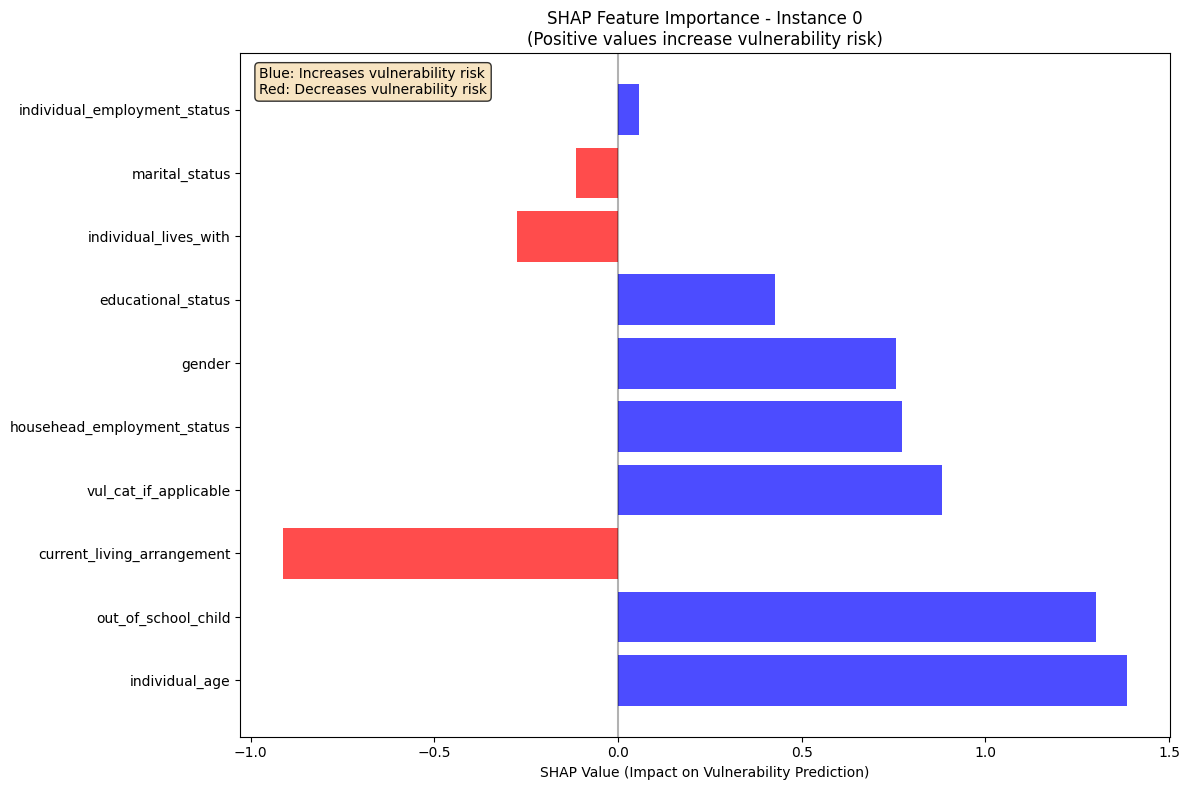


Analyzing Instance 1...

🧾 Instance 1 explanation:
{'instance_idx': 1, 'prediction': 'Not Vulnerable', 'confidence': '100.0%', 'top_features': {'gender': -7.6516, 'individual_age': -1.4075, 'vul_cat_if_applicable': -1.0356, 'individual_employment_status': 0.8284, 'educational_status': -0.4908}, 'reason': 'Social isolation increased vulnerability; Multiple vulnerability factors present', 'suggestions': 'Build community support networks, social protection systems, and peer support groups.; Implement comprehensive, multi-sectoral GBV prevention and response approach addressing individual, relationship, community, and societal factors.'}

GBV VULNERABILITY ANALYSIS - Instance 1
Prediction: Not Vulnerable
Confidence: 100.0%

Top Contributing Features:
  - gender: -7.6516 (decreases vulnerability)
  - individual_age: -1.4075 (decreases vulnerability)
  - vul_cat_if_applicable: -1.0356 (decreases vulnerability)
  - individual_employment_status: 0.8284 (increases vulnerability)
  - educationa

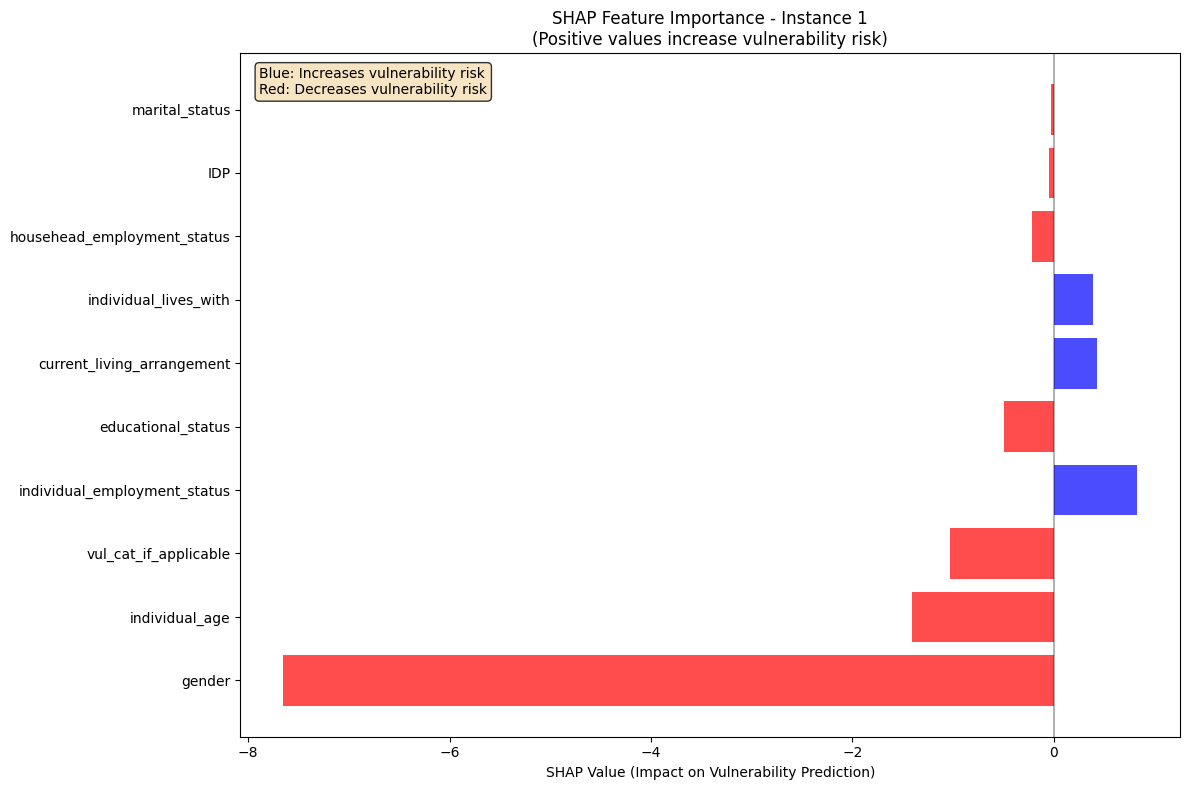


Analyzing Instance 2...

🧾 Instance 2 explanation:
{'instance_idx': 2, 'prediction': 'Not Vulnerable', 'confidence': '99.9%', 'top_features': {'individual_age': -2.8045, 'current_living_arrangement': -1.5818, 'individual_employment_status': -1.4838, 'vul_cat_if_applicable': -1.0356, 'individual_lives_with': -0.9445}, 'reason': 'Gender inequality increased vulnerability; Educational barriers affected vulnerability; Multiple vulnerability factors present', 'suggestions': "Address structural gender inequalities through policy, programming, and women's empowerment initiatives.; Expand access to education, literacy programs, and rights-based awareness initiatives.; Implement comprehensive, multi-sectoral GBV prevention and response approach addressing individual, relationship, community, and societal factors."}

GBV VULNERABILITY ANALYSIS - Instance 2
Prediction: Not Vulnerable
Confidence: 99.9%

Top Contributing Features:
  - individual_age: -2.8045 (decreases vulnerability)
  - current_l

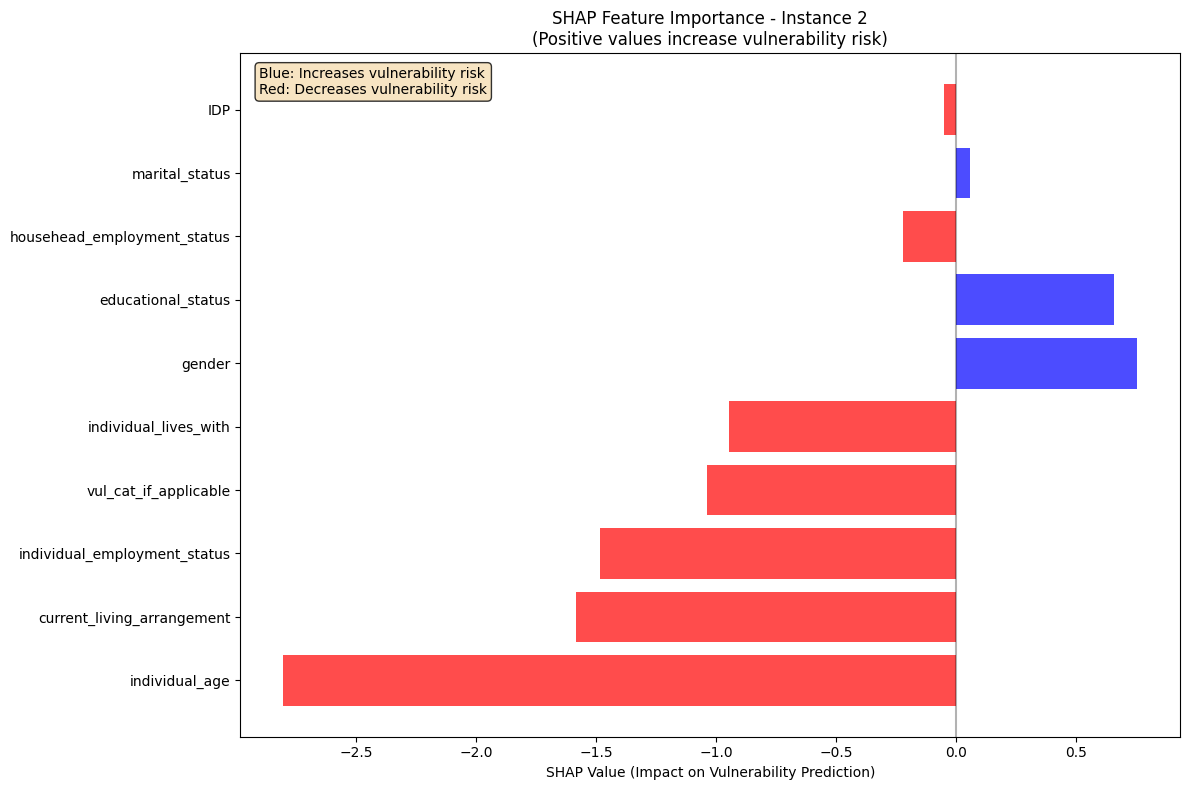


✅ Completed explanation batch.

📋 Explanation Logs:
  instance_idx      prediction confidence  \
0            0      Vulnerable      96.5%   
1            1  Not Vulnerable     100.0%   
2            2  Not Vulnerable      99.9%   

                                              reason  
0  Young age increased vulnerability; Gender ineq...  
1  Social isolation increased vulnerability; Mult...  
2  Gender inequality increased vulnerability; Edu...  


In [83]:

# Initialize SHAP
shap.initjs()

# Create logs DataFrame for storing explanations
logs_df = pd.DataFrame(columns=[
    'instance_idx', 'prediction', 'confidence', 'top_features',
    'reason', 'suggestions', 'shap_explanation'
])

# Label mapping for GBV vulnerability
label_map = {
    0: 'Not Vulnerable',
    1: 'Vulnerable'
}

# GBV-specific rules based on WHO, UNICEF, and research evidence
def rule_gbv_vulnerability_factors(shap_scores, instance_data):
    """
    Rule-based analysis for GBV vulnerability factors based on WHO/UNICEF guidelines
    Updated for correct encodings: 0=Not Vulnerable/Female, 1=Vulnerable/Male
    """
    reasons = []
    suggestions = []
    
    # Age-related vulnerability (younger individuals at higher risk)
    if instance_data.get('individual_age', 25) < 18:  # Under 18 for child vulnerability
        reasons.append("Young age (under 18) is associated with increased GBV vulnerability due to power imbalances and limited autonomy.")
        suggestions.append("Provide age-appropriate GBV prevention education, youth empowerment programs, and protective services.")
    
    # Gender-based risk factors (0=Female, 1=Male)
    if instance_data.get('gender', 0) == 0:  # Female
        reasons.append("Being female significantly increases GBV risk due to structural gender inequalities and patriarchal systems.")
        suggestions.append("Strengthen women's empowerment programs, gender equality initiatives, and female-friendly services.")
    
    # Employment and economic vulnerability (0=Unemployed per your mappings)
    if instance_data.get('individual_employment_status', 1) == 0:  # Unemployed
        reasons.append("Unemployment increases economic dependency and financial vulnerability, raising GBV risk.")
        suggestions.append("Provide economic empowerment programs, vocational training, microfinance, and livelihood skills development.")
    
    # Living arrangements and social support (0=Alone per your mappings)
    if instance_data.get('current_living_arrangement', 1) == 0:  # Living alone
        reasons.append("Living alone reduces available social support networks and protection against GBV.")
        suggestions.append("Connect to community support networks, establish safety planning, and create peer support systems.")
    
    if instance_data.get('individual_lives_with', 1) == 0:  # Lives alone
        reasons.append("Lack of household support increases social isolation and reduces protective factors against GBV.")
        suggestions.append("Facilitate community connections, peer support groups, and social protection services.")
    
    # Educational vulnerability (0=No formal, 1=Some primary per your mappings)
    if instance_data.get('educational_status', 2) <= 1:  # Low education
        reasons.append("Limited education reduces awareness of rights, resources, and increases vulnerability to exploitation and abuse.")
        suggestions.append("Provide literacy programs, rights-based education, legal awareness training, and life skills development.")
    
    # Marital status factors (2=Divorced/separated, 3=Widowed per your mappings)
    if instance_data.get('marital_status', 0) == 2:  # Divorced/separated
        reasons.append("Divorced/separated status correlates with higher GBV risk due to relationship transitions and potential ongoing conflict with ex-partners.")
        suggestions.append("Provide specialized support for relationship transitions, legal aid, safety planning, and counseling services.")
    elif instance_data.get('marital_status', 0) == 3:  # Widowed
        reasons.append("Widowed status can increase vulnerability due to loss of social protection, economic support, and increased isolation.")
        suggestions.append("Provide grief counseling, economic support, community integration programs, and social protection services.")
    
    # Displacement and vulnerability (1=Internally displaced)
    if instance_data.get('IDP', 0) == 1:  # Internally displaced
        reasons.append("Displacement status significantly increases vulnerability due to weakened social networks, loss of community protection, and institutional barriers.")
        suggestions.append("Strengthen protection services in displacement settings, provide legal documentation support, and facilitate safe community integration.")
    
    return len(reasons) > 0, reasons, suggestions

# Define rule-based system for GBV vulnerability (updated for correct encodings)
RULES = [
    ('Young age increased vulnerability', 
     "Implement age-specific GBV prevention and response programs targeting children and minors.", 
     (lambda s, d: d.get('individual_age', 25) < 18, True)),
    
    ('Gender inequality increased vulnerability', 
     "Address structural gender inequalities through policy, programming, and women's empowerment initiatives.", 
     (lambda s, d: d.get('gender', 0) == 0, True)),  # 0 = Female
    
    ('Economic dependency increased risk', 
     "Strengthen economic empowerment, financial inclusion, and sustainable livelihood programs.", 
     (lambda s, d: d.get('individual_employment_status', 1) == 0, True)),  # 0 = Unemployed
    
    ('Social isolation increased vulnerability', 
     "Build community support networks, social protection systems, and peer support groups.", 
     (lambda s, d: d.get('current_living_arrangement', 1) == 0 or d.get('individual_lives_with', 1) == 0, True)),  # 0 = Alone
    
    ('Educational barriers affected vulnerability', 
     "Expand access to education, literacy programs, and rights-based awareness initiatives.", 
     (lambda s, d: d.get('educational_status', 2) <= 1, True)),  # 0-1 = Low education
    
    ('Marital transition risks identified', 
     "Provide specialized support for relationship transitions, legal aid, and comprehensive safety planning.", 
     (lambda s, d: d.get('marital_status', 0) in [2, 3], True)),  # 2=Divorced/separated, 3=Widowed
    
    ('Displacement vulnerability identified', 
     "Strengthen protection services and support systems for displaced populations.", 
     (lambda s, d: d.get('IDP', 0) == 1, True)),  # 1 = Internally displaced
    
    ('Multiple vulnerability factors present',
     "Implement comprehensive, multi-sectoral GBV prevention and response approach addressing individual, relationship, community, and societal factors.",
     (rule_gbv_vulnerability_factors, True))
]

def get_shap_explainer_lr(model, X_background):
    """
    Create SHAP explainer for Logistic Regression model
    """
    return shap.LinearExplainer(model.named_steps['logreg'], 
                               model.named_steps['scaler'].transform(X_background))

def explain_gbv_prediction(instance_idx, model, X_test, X_background, feature_names):
    """
    Generate SHAP explanation for a single GBV prediction
    """
    global logs_df
    
    # Get the instance
    instance = X_test.iloc[instance_idx:instance_idx+1]
    
    # Make prediction
    prediction_proba = model.predict_proba(instance)[0]
    prediction_class = model.predict(instance)[0]
    confidence_val = round(float(np.max(prediction_proba)) * 100, 1)
    confidence = f"{confidence_val}%"
    
    # Create SHAP explainer
    explainer = get_shap_explainer_lr(model, X_background)
    
    # Get SHAP values for the predicted class
    shap_values = explainer.shap_values(model.named_steps['scaler'].transform(instance))
    
    # For binary classification, SHAP returns values for the positive class (class 1)
    # Use the SHAP values as they are (they represent contribution to class 1 - Vulnerable)
    shap_values_to_use = shap_values.flatten() if len(shap_values.shape) == 2 else shap_values
    
    # Get top contributing features
    shap_dict = dict(zip(feature_names, shap_values_to_use))
    top_features = dict(sorted(shap_dict.items(), key=lambda x: abs(x[1]), reverse=True)[:5])
    top_features = {k: round(float(v), 4) for k, v in top_features.items()}
    
    # Extract instance data for rule evaluation
    instance_data = instance.iloc[0].to_dict()
    
    # Apply rules
    reasons, suggestions = [], []
    for reason_text, suggestion_text, rule_tuple in RULES:
        rule_fn, expects_instance_data = rule_tuple
        
        if expects_instance_data:
            if hasattr(rule_fn, '_name') and rule_fn.name_ == 'rule_gbv_vulnerability_factors':
                is_triggered, rule_reasons, rule_suggestions = rule_fn({}, instance_data)
                if is_triggered:
                    reasons.extend(rule_reasons)
                    suggestions.extend(rule_suggestions)
            else:
                if rule_fn({}, instance_data):
                    reasons.append(reason_text)
                    suggestions.append(suggestion_text)
    
    # Create explanation text
    prediction_label = label_map[prediction_class]
    
    shap_explanation = f"""
    SHAP Analysis for Instance {instance_idx}:
    - Prediction: {prediction_label}
    - Confidence: {confidence}
    - Top Contributing Features: {top_features}
    
    Key Vulnerability Factors Identified:
    {chr(10).join([f"- {reason}" for reason in reasons])}
    
    Recommended Interventions:
    {chr(10).join([f"- {suggestion}" for suggestion in suggestions])}
    """
    
    # Log the explanation
    log_entry = {
        'instance_idx': instance_idx,
        'prediction': prediction_label,
        'confidence': confidence,
        'top_features': top_features,
        'reason': "; ".join(reasons),
        'suggestions': "; ".join(suggestions),
        'shap_explanation': shap_explanation
    }
    
    logs_df = pd.concat([logs_df, pd.DataFrame([log_entry])], ignore_index=True)
    
    return log_entry, shap_values_to_use, instance

def plot_shap_explanation(shap_values, instance, feature_names, instance_idx):
    """
    Create SHAP bar plot for a single instance
    """
    plt.figure(figsize=(12, 8))
    
    # Get top 10 features by absolute SHAP value
    shap_abs = np.abs(shap_values)
    top_indices = np.argsort(shap_abs)[-10:][::-1]
    
    top_shap_values = shap_values[top_indices]
    top_feature_names = [feature_names[i] for i in top_indices]
    
    # Create horizontal bar plot
    colors = ['red' if x < 0 else 'blue' for x in top_shap_values]
    
    plt.barh(range(len(top_shap_values)), top_shap_values, color=colors, alpha=0.7)
    plt.yticks(range(len(top_shap_values)), top_feature_names)
    plt.xlabel('SHAP Value (Impact on Vulnerability Prediction)')
    plt.title(f'SHAP Feature Importance - Instance {instance_idx}\n(Positive values increase vulnerability risk)')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    # Add legend
    plt.text(0.02, 0.98, 'Blue: Increases vulnerability risk\nRed: Decreases vulnerability risk', 
             transform=plt.gca().transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def run_gbv_explanations(model, X_test, max_instances=3):
    """
    Run SHAP explanations for GBV vulnerability predictions
    """
    print(f"Generating SHAP explanations for {max_instances} instances...")
    
    # Create background data for SHAP
    X_background = X_test.sample(n=min(100, len(X_test)), random_state=42)
    feature_names = X_test.columns.tolist()
    
    for idx in range(min(max_instances, len(X_test))):
        print(f"\nAnalyzing Instance {idx}...")
        
        # Generate explanation
        log_entry, shap_values, instance = explain_gbv_prediction(
            idx, model, X_test, X_background, feature_names
        )
        
        # Print explanation similar to your boss's format
        print(f"\n🧾 Instance {idx} explanation:")
        explanation_dict = {
            'instance_idx': log_entry['instance_idx'],
            'prediction': log_entry['prediction'],
            'confidence': log_entry['confidence'],
            'top_features': log_entry['top_features'],
            'reason': log_entry['reason'],
            'suggestions': log_entry['suggestions']
        }
        print(explanation_dict)
        
        # Also print detailed analysis
        print("\n" + "="*60)
        print(f"GBV VULNERABILITY ANALYSIS - Instance {idx}")
        print("="*60)
        print(f"Prediction: {log_entry['prediction']}")
        print(f"Confidence: {log_entry['confidence']}")
        print(f"\nTop Contributing Features:")
        for feature, importance in log_entry['top_features'].items():
            direction = "increases vulnerability" if importance > 0 else "decreases vulnerability"
            print(f"  - {feature}: {importance:.4f} ({direction})")
        
        print(f"\nKey Reasons:")
        if log_entry['reason']:
            for reason in log_entry['reason'].split('; '):
                print(f"  - {reason}")
        else:
            print("  - No specific vulnerability factors identified in this instance")
        
        print(f"\nRecommended Actions:")
        if log_entry['suggestions']:
            for suggestion in log_entry['suggestions'].split('; '):
                print(f"  - {suggestion}")
        else:
            print("  - Continue monitoring and maintain current protection measures")
        
        # Create SHAP plot
        plot_shap_explanation(shap_values, instance, feature_names, idx)
    
    print("\n✅ Completed explanation batch.")
    print("\n📋 Explanation Logs:")
    print(logs_df[['instance_idx', 'prediction', 'confidence', 'reason']].head())
    
    return logs_df

print("GBV Vulnerability SHAP Explanation System Ready!")
print("Usage: run_gbv_explanations(your_logistic_regression_model, your_X_test_data)")

# Run the explanations immediately using your best_model (Logistic Regression)
print("\n🔎 Explaining top 3 instances with SHAP analysis...")
explanations_log = run_gbv_explanations(best_model, X_test, max_instances=3)